# 以 SARSA 求解 Cliff Walking

## 載入套件

In [12]:
import matplotlib
import numpy as np
import random
import sys
import gymnasium as gym

## 載入遊戲

In [13]:
env = gym.make('CliffWalking-v0')

## 測試遊戲規則

In [14]:
up, right, down, left = 0, 1, 2, 3
# 走到斷崖
state, _ = env.reset()
state, reward, terminated, truncated, info = env.step(right)
done = terminated or truncated
print('走到斷崖:')
print(f'total reward={reward}, done={done}')

# 往上走
state, _ = env.reset()
state, reward, terminated, truncated, info = env.step(up)
done = terminated or truncated
print('往上走:')
print(f'total reward={reward}, done={done}')

# 走到終點
print('走到終點:')
acc_reward=0
state, _ = env.reset()
state, reward, terminated, truncated, info = env.step(up)
acc_reward+=reward
for _ in range(12):
    state, reward, terminated, truncated, info = env.step(right)
    done = terminated or truncated
    acc_reward+=reward
    # print(f'reward=:{reward}, done:{done}')
state, reward, terminated, truncated, info = env.step(down)
done = terminated or truncated
acc_reward+=reward
print(f'total reward={acc_reward}, done={done}')
state

走到斷崖:
total reward=-100, done=False
往上走:
total reward=-1, done=False
走到終點:
total reward=-14, done=True


47

## 定義 ε-greedy策略

In [15]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        # 每個行動的機率初始化，均為 ε / n
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        # 最佳行動的機率再加 1 - ε 
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

## 定義 SARSA 策略

In [16]:
from collections import defaultdict
from lib import plotting
import itertools

def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # 行動值函數初始化
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # 記錄 所有回合的長度及獎勵
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # 使用 ε-greedy策略
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # 實驗 N 回合
    for i_episode in range(num_episodes):
        # 每 100 回合顯示除錯訊息
        if (i_episode + 1) % 100 == 0:
            print(f"\r {(i_episode + 1)}/{num_episodes}回合.", end="")
            sys.stdout.flush() # 清除畫面
        
        # 開始依策略實驗
        state, _ = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # 每次走一步就更新狀態值
        for t in itertools.count():
            # 走一步
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # 選擇下一步行動
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs))
                                           , p=next_action_probs)
            
            # 更新長度及獎勵
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # 更新狀態值
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

## 執行 SARSA 策略

In [17]:
Q, stats = sarsa(env, 1000, discount_factor=0.9, alpha=0.5, epsilon=0.1)

 1000/1000回合.

## 顯示執行結果

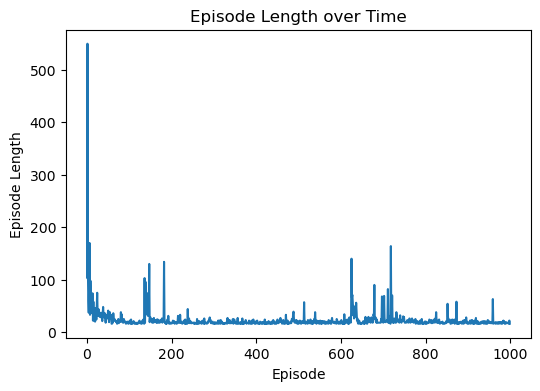

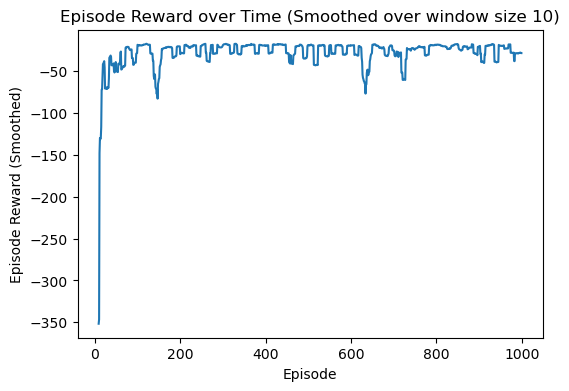

In [18]:
fig = plotting.plot_episode_stats(stats)

In [19]:
Q

defaultdict(<function __main__.sarsa.<locals>.<lambda>()>,
            {36: array([  -8.80558842, -110.75524797,  -14.95092947,  -10.52764585]),
             24: array([-8.52556426, -9.54490643, -9.19589582, -9.41885639]),
             12: array([-8.34525375, -9.03103478, -9.37660822, -9.05429546]),
             0: array([-9.42221266, -8.13337548, -9.92480421, -8.96604484]),
             1: array([-8.4195816 , -7.75377989, -8.86233242, -8.90127555]),
             2: array([-7.9752682 , -7.52097664, -9.86131707, -8.69142615]),
             13: array([ -8.16932983, -14.66225034,  -9.401973  ,  -9.2953247 ]),
             14: array([ -8.62731164,  -7.87655174, -10.67288344,  -8.79511921]),
             3: array([-8.13093087, -7.26933045, -7.96830993, -8.27444386]),
             4: array([-7.38537585, -6.94874951, -7.49175493, -7.90822295]),
             5: array([-7.33868379, -6.50861672, -7.67600935, -7.86047323]),
             6: array([-7.26408207, -5.96322797, -7.05557404, -7.49359316

## 將行動策略轉換為最佳行動

In [20]:
dict1 = {0:'U', 1:'R', 2:'D', 3:'L'}
for row in range(4):
    for column in range(12):
        print(dict1[np.argmax(Q[row * 12 + column])], ' ', end='')
    print()

R  R  R  R  R  R  R  R  R  R  D  D  
U  U  R  U  U  U  U  U  U  U  R  D  
U  L  R  U  U  U  U  U  U  L  R  D  
U  U  U  U  U  U  U  U  U  U  U  U  


In [21]:
column
dict1[np.argmax(Q[column * 12 + row])]

'U'

## 測試行動策略

In [22]:
def play_episodes(environment, n_episodes, policy):
    wins = 0
    total_reward = 0
    for episode in range(n_episodes):
            done = False
            state, info = environment.reset()
            while not done:
                    # Select best action to perform in a current state
                    action = np.argmax(policy[state])
                    # Perform an action an observe how environment acted in response
                    next_state, reward, terminated, truncated, info = environment.step(action)
                    done = terminated or truncated
                    # Summarize total reward
                    total_reward += reward
                    # Update current state
                    state = next_state
                    # Calculate number of wins over episodes
                    if done and reward > -100:
                            wins += 1
    average_reward = total_reward / n_episodes
    return wins, total_reward, average_reward

# 測試 1000 回合
n_episodes = 1000
wins, total_reward, average_reward = play_episodes(env, n_episodes, Q)
print(f'number of wins over {n_episodes} episodes = {wins}')
print(f'average reward over {n_episodes} episodes = {average_reward} \n\n')

number of wins over 1000 episodes = 1000
average reward over 1000 episodes = -17.0 


